CK+ - CNN

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
df = pd.read_csv('C:/Kecilin/emotion_detection/V3/ckextended.csv')
df.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [3]:
label_to_text = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}

# Define the new class mapping
new_classes = {
    1: ['Happiness', 'Surprise'],  # Positive
    0: ['Neutral'],  # Neutral
    2: ['Anger', 'Disgust', 'Fear', 'Sadness', 'Contempt']  # Negative
}

# Create a dictionary to map old labels to new labels
new_label_mapping = {}
for new_label, old_classes in new_classes.items():
    for old_label, old_class in label_to_text.items():
        if old_class in old_classes:
            new_label_mapping[old_label] = new_label

In [4]:
img_array = df.pixels.apply(lambda x: np.array(x.split(" ")).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [5]:
img_array.shape

(920, 48, 48, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size= .2)

In [7]:
X_train = X_train/255
X_test = X_test/255

In [8]:
# Flatten the input data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Normalize your data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)

# Reshape the data back to its original shape
X_train_normalized = X_train_normalized.reshape(X_train.shape)
X_test_normalized = X_test_normalized.reshape(X_test.shape)

In [9]:
# Update the labels using the new label mapping
y_train_updated = np.array([new_label_mapping[label] for label in y_train])
y_test_updated = np.array([new_label_mapping[label] for label in y_test])

In [11]:
basemodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='linear')
])

In [12]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 64)        256       
 chNormalization)                                                
                                                        

In [13]:
initial_learning_rate = 0.001  # You can adjust this value
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
basemodel.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [14]:
# def lr_schedule(epoch):
#     if epoch < 20:
#         return initial_learning_rate
#     else:
#         return initial_learning_rate * 0.1

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by a factor of 0.5
    patience=5,          # If no improvement after 5 epochs, reduce the learning rate
    min_lr=1e-6          # Minimum learning rate
)

In [15]:
file_name = 'best_model_with_reducelronplateau.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_freq='epoch',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='max'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True
    ),
    # tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    reduce_lr
]

In [16]:
history = basemodel.fit(X_train_normalized, y_train_updated,
                        epochs=50,
                        batch_size=8,
                        validation_data=(X_test_normalized, y_test_updated),
                        callbacks=call_back)

Epoch 1/50


91/92 [============================>.] - ETA: 0s - loss: 1.1579 - accuracy: 0.5852
Epoch 1: val_accuracy improved from -inf to 0.67935, saving model to checkpoint\best_model_with_reducelronplateau.h5
92/92 [==============================] - 4s 31ms/step - loss: 1.1567 - accuracy: 0.5856 - val_loss: 1.1132 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 2/50
 3/92 [..............................] - ETA: 2s - loss: 0.7610 - accuracy: 0.7500

C:\Users\vince\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.7473
Epoch 2: val_accuracy did not improve from 0.67935
92/92 [==============================] - 3s 32ms/step - loss: 0.7085 - accuracy: 0.7473 - val_loss: 2.4312 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 3/50
91/92 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.7761
Epoch 3: val_accuracy did not improve from 0.67935
92/92 [==============================] - 3s 29ms/step - loss: 0.6031 - accuracy: 0.7745 - val_loss: 2.4943 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 4/50
91/92 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.8104
Epoch 4: val_accuracy improved from 0.67935 to 0.71196, saving model to checkpoint\best_model_with_reducelronplateau.h5
92/92 [==============================] - 3s 31ms/step - loss: 0.4964 - accuracy: 0.8111 - val_loss: 0.9280 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 5/50
90/92 [============================>.] - ETA: 0s - loss: 0.4019 - a

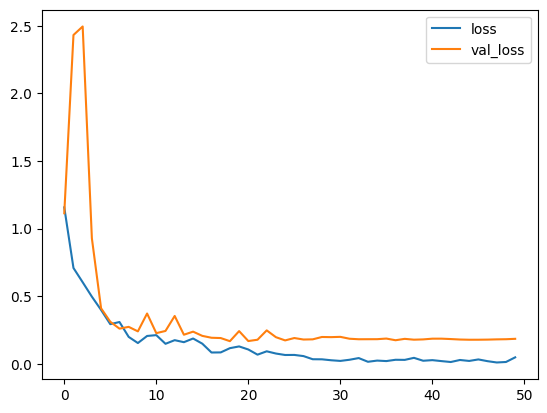

In [17]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

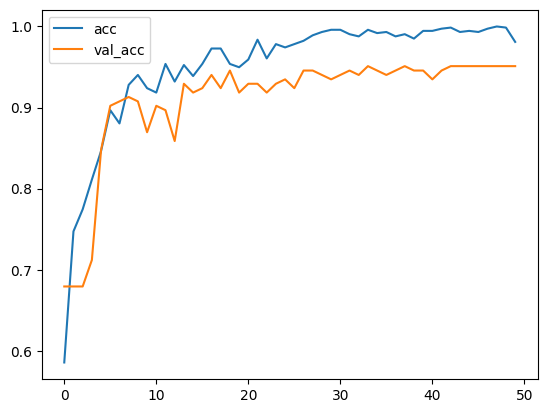

In [18]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

6/6 [==============================] - 0s 14ms/step
Confusion matrix, without normalization
[[  0   0  13   0   0   0   0   0]
 [  0   0  13   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0]
 [  1   0   8   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0]
 [  0   0  15   0   0   0   0   0]
 [  0   0 125   0   0   0   0   0]
 [  0   0   3   0   0   0   0   0]]


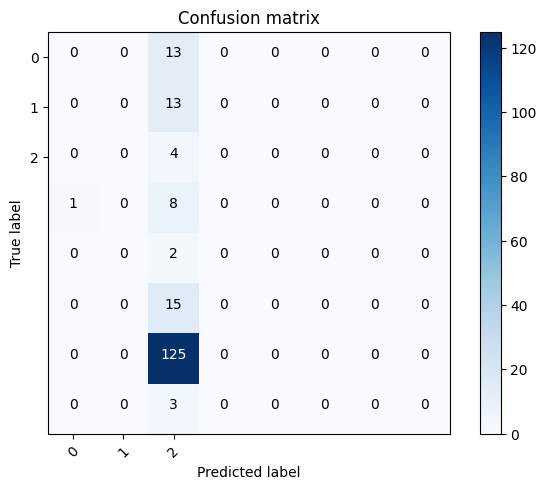

In [19]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = basemodel.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(3)))

In [20]:
checkpoint_path

'checkpoint\\best_model_with_reducelronplateau.h5'

In [21]:
# final_model = tf.keras.models.load_model(checkpoint_path)
# from IPython.display import clear_output
# import time

# for k in range(40):
#         print(f'actual label is {label_to_text[y_test[k]]}')
#         predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
#         print(f'predicted label is {label_to_text[predicted_class]}')
#         pyplot.imshow(X_test[k].reshape((48,48)))
#         pyplot.show()
#         time.sleep(3)
#         clear_output(wait=True)